Chapter 6

6-1 신경망 알고리즘을 벡터화

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [28]:
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [29]:
#단일층 신경망에 배치 경사 하강법 적용

class SingleLayer:
  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x): #정방향 계산
    z = np.dot(x, self.w) + self.b #선형 출력 계산
    return z

  def backprop(self, x, err): #역방향 계산
    m = len(x)
    w_grad = np.dot(x.T, err) / m
    b_grad = np.sum(err) / m
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): #훈련을 위한 fit() 매서드 구현
    y = y.reshape(-1, 1) #타깃을 열벡터로 변형
    y_val = y_val.reshape(-1, 1) #검증용 타깃을 열벡터로 변형
    m = len(x)
    self.w = np.ones((x.shape[1],1))
    self.b = 0
    self.w_history.append(self.w.copy())
    for i in range(epochs):
      z = self.forpass(x)
      a = self.activation(z)
      err = -(y - a)
      w_grad, b_grad = self.backprop(x, err)
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m # 그레이디언트에서 페널티 항의 미분값을 더함
      self.w -= self.lr * w_grad
      self.b -= self.lr * b_grad
      self.w_history.append(self.w.copy()) #가중치를 기록
      a = np.clip(a, 1e-10, 1-1e-10) #안전한 로그 계산을 위해 클리핑한 후 손실을 누적
      loss = np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m) #에포크마다 평균 손실을 저장
      self.update_val_loss(x_val, y_val) #검증 세트에 대한 손실을 계산

  def predict(self, x): #예측을 위한 predict() 매서드 구현
    z = self.forpass(x)
    return z > 0

  def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(-1, 1))

  def reg_loss(self): #로지스틱 손실 함수 계산에 페널티 항 추가
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  def update_val_loss(self, x_val, y_val):   #검증 손실 계산
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-(y_val*np.log(a)+(1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [30]:
#훈련 데이터 표준화 전처리
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [31]:
#배치 경사 하강법을 적용
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

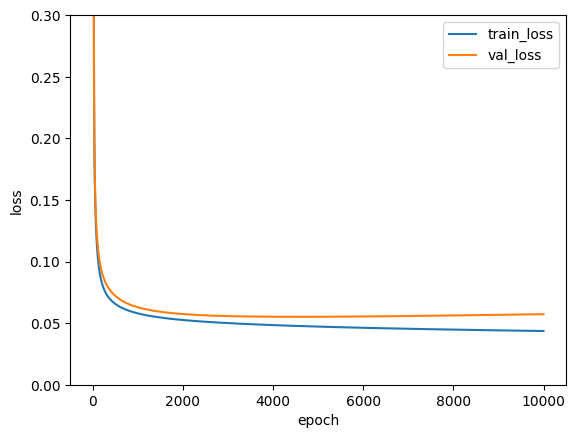

In [32]:
#검증 세트로 성능을 측정하고 그래프로 비교
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

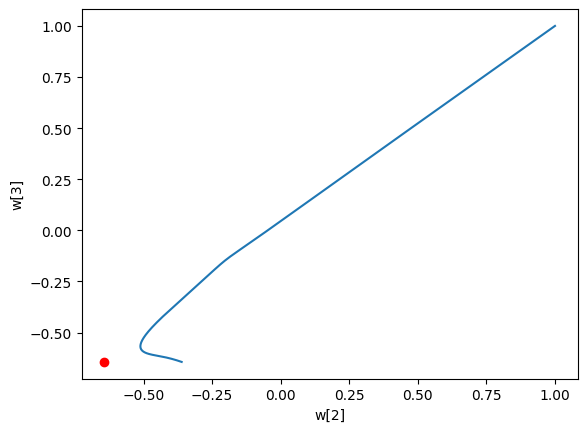

In [33]:
w2 = []
w3 = []
for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w3[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

6-2 2개의 층을 가진 신경망 구현

In [34]:
class DualLayer(SingleLayer):

  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
    self.units = units
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.activation(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2

  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def init_weights(self, n_features):
    self.w1 = np.ones((n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.ones((self.units, 1))
    self.b2 = 0

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.init_weights(x.shape[1])
    for i in range(epochs):
      a = self.training(x, y, m)
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)

  def training(self, x, y, m):
    z = self.forpass(x)
    a = self.activation(z)
    err = -(y-a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def reg_loss(self): #로지스틱 손실 함수 계산에 페널티 항 추가
    return self.l1 * np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2)) +\
           self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [35]:
#다층 신경망 모델 훈련하고 평가
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

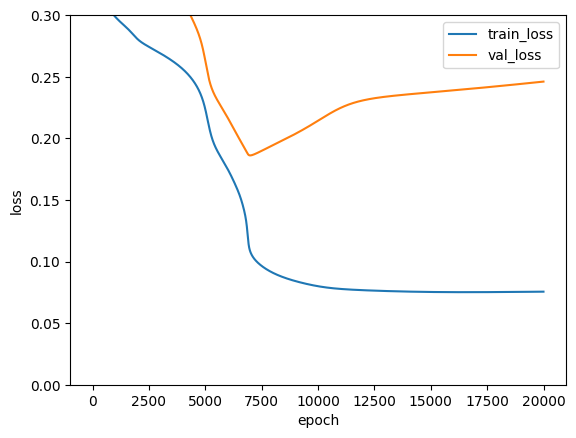

In [36]:
#훈련 손실과 검증 손실 그래프 분석
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [37]:
#가중치 초기화 개선
class RandomInitNetwork(DualLayer):

  def init_weights(self, n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, 1))
    self.b2 = 0

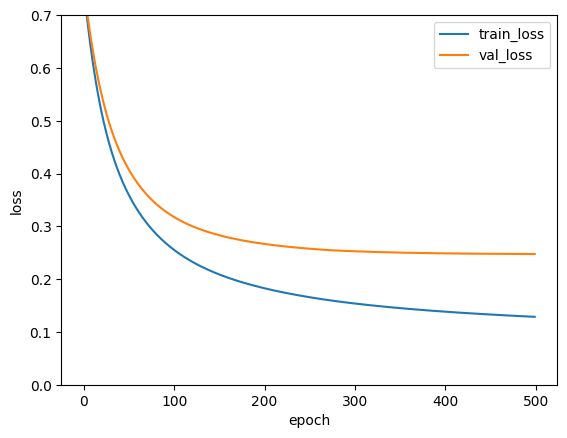

In [38]:
#훈련 손실과 검증 손실 그래프 분석
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

plt.ylim(0, 0.7)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

6-3 미니 배치를 사용하여 모델 훈련